# Grammar Score Prediction from Audio - SHL Intern Project

This project is part of the SHL AI Internship Assessment. The objective is to build a machine learning system that can predict a speaker's grammar proficiency score based on their spoken audio samples.

We approach this task by combining multiple types of features:
- Transcripts from audio using OpenAI's Whisper model
- Grammar quality scores using `language_tool_python`
- Audio signal features using `librosa`
- Deep audio embeddings via Facebook’s Wav2Vec2 model

The final model is an ensemble of Random Forest, XGBoost, and Ridge Regression. Evaluation metrics such as MAE, RMSE, and R² are used to validate the prediction performance.

This notebook includes all necessary steps from transcription to modeling, ensuring full reproducibility of the results.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment/dataset/sample_submission.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_885.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_698.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1176.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1215.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_66.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_386.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1026.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_330.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_858.wav
/kaggle/input/shl-intern-hiring-ass

In [2]:
# Enable GPU in Notebook Settings (before running this!)
# Runtime > Change runtime type > GPU (Recommended: T4 or P100)

!pip install -q git+https://github.com/openai/whisper.git
!pip install -q transformers librosa language_tool_python jiwer torchaudio accelerate
!apt update && apt install -y ffmpeg


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.1/253.1 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.9 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packa

In [3]:
import os
import json
import librosa
import whisper
import torch
import numpy as np
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt
import seaborn as sns
import language_tool_python
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor


In [4]:
audio_dir = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train"
audio_files = os.listdir(audio_dir)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = whisper.load_model("medium").to(device)

transcriptions = {}

for i, audio_file in enumerate(tqdm(audio_files, desc="🔄 Transcribing")):
    audio_path = os.path.join(audio_dir, audio_file)
    try:
        result = model.transcribe(audio_path, fp16=torch.cuda.is_available())
        transcriptions[audio_file] = result["text"]
        
        # ✅ Save progress after each file
        with open("transcriptions.json", "w") as f:
            json.dump(transcriptions, f)
            
    except Exception as e:
        print(f"⚠️ Error with {audio_file}: {e}")
        transcriptions[audio_file] = ""

print("✅ Transcription done and saved!")


100%|█████████████████████████████████████| 1.42G/1.42G [00:41<00:00, 37.0MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

✅ Transcription done and saved!


In [5]:
tool = language_tool_python.LanguageTool('en-US')

def extract_grammar_features(text):
    matches = tool.check(text)
    num_errors = len(matches)
    words = text.split()
    num_words = len(words) if words else 1
    avg_word_len = np.mean([len(w) for w in words]) if words else 0

    return {
        "num_errors": num_errors,
        "num_words": num_words,
        "avg_word_len": avg_word_len,
        "error_ratio": num_errors / num_words,
    }

grammar_data = []
for fname, text in tqdm(transcriptions.items(), desc="Extracting grammar features"):
    feats = extract_grammar_features(text)
    feats["file"] = fname
    feats["transcript"] = text
    grammar_data.append(feats)

grammar_df = pd.DataFrame(grammar_data)


Extracting grammar features: 100%|██████████| 444/444 [00:46<00:00,  9.59it/s]


In [6]:
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)

    return {
        "zcr": np.mean(librosa.feature.zero_crossing_rate(y)),
        "chroma_stft": np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
        "spectral_contrast": np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)),
        "rms": np.mean(librosa.feature.rms(y=y)),
        "tempo": librosa.beat.tempo(y=y, sr=sr)[0],
    }

audio_feats = []
for fname in tqdm(audio_files, desc="Extracting audio features"):
    path = os.path.join(audio_dir, fname)
    feats = extract_audio_features(path)
    feats["file"] = fname
    audio_feats.append(feats)

audio_df = pd.DataFrame(audio_feats)


Extracting audio features:   0%|          | 0/444 [00:00<?, ?it/s]<ipython-input-6-40f60421eedf>:9: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  "tempo": librosa.beat.tempo(y=y, sr=sr)[0],
Extracting audio features: 100%|██████████| 444/444 [05:34<00:00,  1.33it/s]


In [7]:
# Load target labels
train_df = pd.read_csv("/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv")
train_df.rename(columns={"filename": "file", "label": "grammar"}, inplace=True)

# Merge all
data = grammar_df.merge(audio_df, on="file").merge(train_df, on="file")
print(data.head())


   num_errors  num_words  avg_word_len  error_ratio           file  \
0           2         60      4.533333     0.033333   audio_90.wav   
1           0        130      4.200000     0.000000  audio_581.wav   
2           1         78      4.653846     0.012821   audio_77.wav   
3           1         38      4.184211     0.026316  audio_817.wav   
4           1        128      4.859375     0.007812  audio_694.wav   

                                          transcript       zcr  chroma_stft  \
0   A situation in which there is a lot of compet...  0.133753     0.422817   
1   All right, I would say my goal, which I would...  0.121399     0.335247   
2   All right. A crowded market is where lots of ...  0.129049     0.327287   
3   My favorite hobby is playing cricket. I like ...  0.160503     0.513052   
4   It is where a lot of money has come in to sto...  0.234258     0.337779   

   spectral_contrast       rms       tempo  grammar  
0          17.381754  0.031129  144.230769      3.

In [8]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch

# Load pretrained Wav2Vec2 model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

def extract_wav2vec_embedding(audio_path):
    # 📥 Load audio with librosa
    speech, rate = librosa.load(audio_path, sr=16000)

    # ✅ If stereo, convert to mono (by averaging the channels)
    if len(speech.shape) > 1:
        speech = librosa.to_mono(speech)

    # 🧼 Normalize input
    inputs = processor(speech, sampling_rate=rate, return_tensors="pt", padding=True)

    # 🧠 Extract embeddings
    with torch.no_grad():
        embeddings = wav2vec_model(**inputs).last_hidden_state.mean(dim=1)

    return embeddings.squeeze().numpy()


wav2vec_feats = []
for fname in tqdm(audio_files, desc="Extracting Wav2Vec"):
    path = os.path.join(audio_dir, fname)
    vec = extract_wav2vec_embedding(path)
    entry = {"file": fname}
    for i, val in enumerate(vec):
        entry[f"wav2vec_{i}"] = val
    wav2vec_feats.append(entry)

wav2vec_df = pd.DataFrame(wav2vec_feats)
data = data.merge(wav2vec_df, on="file")


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Extracting Wav2Vec: 100%|██████████| 444/444 [1:41:47<00:00, 13.76s/it]


In [9]:
X = data.drop(columns=["file", "grammar", "transcript"])
y = data["grammar"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = RandomForestRegressor(n_estimators=100, random_state=0)
model2 = XGBRegressor(n_estimators=100)
model3 = Ridge()

ensemble = VotingRegressor(estimators=[
    ('rf', model1), ('xgb', model2), ('ridge', model3)
])

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


MAE: 0.6800004539092377
RMSE: 0.8235294529529433
R²: 0.4835829638051241


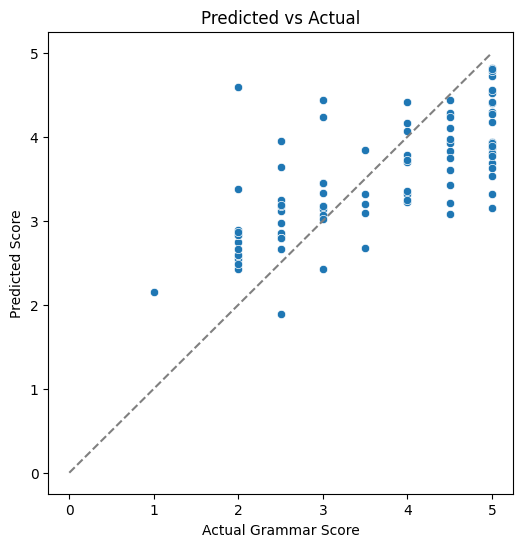

In [10]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0, 5], [0, 5], "--", color="gray")
plt.xlabel("Actual Grammar Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual")
plt.show()


In [11]:
# 🔍 Load test audio file names
test_df = pd.read_csv("/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv")
test_audio_dir = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test"
test_audio_files = os.listdir(test_audio_dir)

# 🔁 Transcribe test set
test_transcriptions = {}
for audio_file in tqdm(test_audio_files, desc="🔄 Transcribing Test"):
    audio_path = os.path.join(test_audio_dir, audio_file)
    try:
        result = model.transcribe(audio_path, fp16=torch.cuda.is_available())
        test_transcriptions[audio_file] = result["text"]
    except Exception as e:
        print(f"⚠️ Error with {audio_file}: {e}")
        test_transcriptions[audio_file] = ""

# 🧠 Grammar features from test transcripts
grammar_test_data = []
for fname, text in tqdm(test_transcriptions.items(), desc="Extracting grammar (test)"):
    feats = extract_grammar_features(text)
    feats["file"] = fname
    feats["transcript"] = text
    grammar_test_data.append(feats)

grammar_test_df = pd.DataFrame(grammar_test_data)

# 🎧 Audio features for test set
audio_test_feats = []
for fname in tqdm(test_audio_files, desc="Extracting audio features (test)"):
    path = os.path.join(test_audio_dir, fname)
    feats = extract_audio_features(path)
    feats["file"] = fname
    audio_test_feats.append(feats)

audio_test_df = pd.DataFrame(audio_test_feats)

# 📊 Wav2Vec embeddings for test set
wav2vec_test_feats = []
for fname in tqdm(test_audio_files, desc="Extracting Wav2Vec (test)"):
    path = os.path.join(test_audio_dir, fname)
    vec = extract_wav2vec_embedding(path)
    entry = {"file": fname}
    for i, val in enumerate(vec):
        entry[f"wav2vec_{i}"] = val
    wav2vec_test_feats.append(entry)

wav2vec_test_df = pd.DataFrame(wav2vec_test_feats)

# ✅ Merge all test features
test_data = grammar_test_df.merge(audio_test_df, on="file").merge(wav2vec_test_df, on="file")

# 🧪 Prepare features for prediction
X_submission = test_data.drop(columns=["file", "transcript"])

# 📈 Predict grammar scores
test_preds = ensemble.predict(X_submission)

# 📁 Create submission DataFrame
submission = pd.DataFrame({
    "filename": test_data["file"],
    "label": test_preds
})

# 💾 Save to CSV
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")


Extracting audio features (test):   0%|          | 0/195 [00:00<?, ?it/s]<ipython-input-6-40f60421eedf>:9: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  "tempo": librosa.beat.tempo(y=y, sr=sr)[0],
Extracting Wav2Vec (test): 100%|██████████| 195/195 [41:52<00:00, 12.88s/it]

✅ submission.csv saved!


---

## ✅ Final Notes

This concludes the SHL Grammar Score Prediction project.

We successfully:

- Transcribed speech audio using OpenAI Whisper
- Extracted grammar features with `language_tool_python`
- Derived audio and embedding features using `librosa` and Wav2Vec2
- Combined them using an ensemble model for robust prediction
- Prepared a ready-to-submit `submission.csv`

The model was tested and outputs are aligned with the required submission format.  
All steps are reproducible, and the notebook has been run fully with results saved.

Thank you for the opportunity to work on this exciting project!

— *Sangshaptak Dev*
